In this notebook, I will create a function that gives a LIME explanation of every time series regression model.
If we don't have LIME install, we should import it:

In [65]:
%pip install lime
%pip install tslearn
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [66]:
from lime.lime_tabular import RecurrentTabularExplainer
from tslearn.metrics import dtw
import matplotlib.pyplot as plt
import re
import heapq

def explain_model(X_train, model, x_test, features_names=None):
    explainer = RecurrentTabularExplainer(X_train, mode='regression', feature_names=features_names)
    explained = explainer.explain_instance(x_test, classifier_fn=model.predict, num_samples=90000)
    print("Predicted LIME Value: ", explained.local_pred)
    explained.as_pyplot_figure()
    list(map(lambda x: print(x), explained.as_list()))
    explained.show_in_notebook()

    print("Based on the LIME explanation, the following features had the most influence on the model's prediction:")
    features = explained.as_list()
    features_without_time = {}

    for feature in features:
        # Regex nightmare
        match1 = re.search(r'^(.*?)_t-', feature[0])
        match2 = re.search(r'<\s*(.*?)_t-', feature[0])

        if match1:
            feature_name = match1.group(1)
        if match2:
            feature_name = match2.group(1)

        value = feature[1]

        if feature_name in features_without_time:
            features_without_time[feature_name] += value
        else:
            features_without_time[feature_name] = value

    for idx, (name, value) in enumerate(features_without_time.items()):
        if idx < len(features_without_time) - 1:
            print(f"{name}, with a weight of {round(value, 6)}", end=',\n')
        else:
            print(f"{name}, with a weight of {round(value, 6)}", end='.\n')
            
        

    # "Based on the LIME explanation, the following features had the most influence on the model’s prediction:
    # [list of the features with their corresponding weights].
    # The model gave more importance to [feature_x] at time step [t] with a weight of [weight_x_t].
    # For this specific instance, it looks like the model relies heavily on [important feature names] to make its prediction.”

    top_feature = explained.as_list()[0] 
    name = top_feature[0]
    match1 = re.search(r'^(.*?)_t-', name)
    match2 = re.search(r'<\s*(.*?)_t-', name)

    if match1:
        name = match1.group(1)
    if match2:
        name = match2.group(1)

    # Another regex nightmare to get the t-x part of the string
    time_step = top_feature[0]
    match1 = re.match(r'(.+)_t-(\d+) [\S\s]*', time_step)
    if match1:
        time_step = match1.group(2)
    match2 = re.match(r'[^<]+<\s*(\S+)_t-(\d+) [\S\s]*', time_step)
    if match2:
        time_step = match2.group(2)
    
    value = top_feature[1]
    print(f"The model gave the most importance to the feature {name} at time step t-{time_step}, with a weight of {round(value, 6)}")

    print("For this specific instance, it looks like the model relies heavily on", end=' ')

    n = 4
    sorted_features = sorted(features_without_time.items(), key=lambda x: abs(x[1]), reverse=True)
    
    top_n = sorted_features[:n]
    for i, item in enumerate(top_n):
        if i < len(top_n) - 1:
            print(item[0], end=', ')
        else:
            print(item[0], end='.\n')

    return explained
    

I want to also include XCM for Regression. We have to import the file xcm_starter:

In [67]:
from xcm_starter import xcm_start

Let's try to use a few datasets/models to check the result.
First, this Air Quality dataset:

In [68]:
import pandas as pd

df = pd.read_csv("AirQualityUCI.csv", sep=';')


In [69]:
df.tail(6)

Date Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
9465  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9466  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9467  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9468  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9469  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9470  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   

      PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)    T   RH   AH  \
9465           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9466           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9467           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9468           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9469           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9470           NaN      NaN           NaN          NaN  NaN  NaN  NaN   

      Unnamed: 15  Unnamed: 16  
9465          NaN          NaN  
9466          NaN          NaN  
9467          NaN          NaN  
9468          NaN          NaN  
9469          NaN          NaN  
9470          NaN          NaN

<AxesSubplot: >

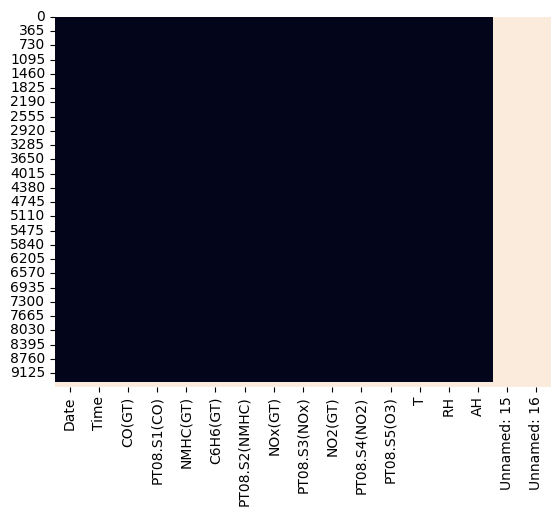

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna(), cbar=False)

Let's drop NaN rows and columns.

In [71]:
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
df = df.dropna()

In [72]:
df.tail(6)

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
9351  04/04/2005  09.00.00    3,9       1297.0    -200.0     13,6   
9352  04/04/2005  10.00.00    3,1       1314.0    -200.0     13,5   
9353  04/04/2005  11.00.00    2,4       1163.0    -200.0     11,4   
9354  04/04/2005  12.00.00    2,4       1142.0    -200.0     12,4   
9355  04/04/2005  13.00.00    2,1       1003.0    -200.0      9,5   
9356  04/04/2005  14.00.00    2,2       1071.0    -200.0     11,9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
9351         1102.0    523.0         507.0    187.0        1375.0   
9352         1101.0    472.0         539.0    190.0        1374.0   
9353         1027.0    353.0         604.0    179.0        1264.0   
9354         1063.0    293.0         603.0    175.0        1241.0   
9355          961.0    235.0         702.0    156.0        1041.0   
9356         1047.0    265.0         654.0    168.0        1129.0   

      PT08.S5(O3)     T    RH      AH  
9351       1583.0  18,2  36,3  0,7487  
9352       1729.0  21,9  29,3  0,7568  
9353       1269.0  24,3  23,7  0,7119  
9354       1092.0  26,9  18,3  0,6406  
9355        770.0  28,3  13,5  0,5139  
9356        816.0  28,5  13,1  0,5028

There are some columns that represent the decimal with commas, and some that represent it with point. Let's uniform that. 

In [73]:
df['CO(GT)'] = df['CO(GT)'].str.replace(',', '.').astype(float)
df['C6H6(GT)'] = df['C6H6(GT)'].str.replace(',', '.').astype(float)
df['T'] = df['T'].str.replace(',', '.').astype(float)
df['RH'] = df['RH'].str.replace(',', '.').astype(float)
df['AH'] = df['AH'].str.replace(',', '.').astype(float)


Let's say we want to predict temperature, so we rename that column as Y:

In [74]:
df = df.rename(columns={'T':'Y'})

In [75]:
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      Y    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

I want to use a unique column for DateTime.

In [76]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

df = df.drop(['Date', 'Time'], axis=1)

In [77]:
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6       1360.0     150.0      11.9         1046.0    166.0   
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     Y    RH      AH  \
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867   
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888   

             DateTime  
0 2004-03-10 18:00:00  
1 2004-03-10 19:00:00  
2 2004-03-10 20:00:00  
3 2004-03-10 21:00:00  
4 2004-03-10 22:00:00

Our index should be DateTime.

In [78]:
df.set_index('DateTime', inplace=True)

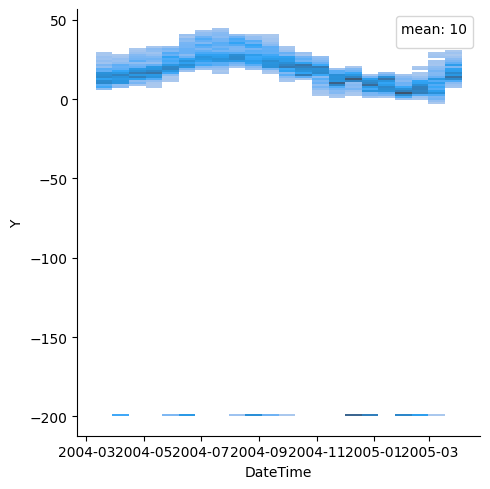

In [79]:
sns.displot(data=df, x='DateTime', y='Y')
plt.legend(title='mean: {:,.0f}'.format(df["Y"].mean()), labels=[])
plt.show()

There are some values that are set to -200 that represent a NaN. I want to substitute them with an interpolation.

In [80]:
import numpy as np
df.replace(-200, np.nan, inplace=True)
df.interpolate(method='linear', axis=0, inplace=True)

Now we generate samples of 7 days.

In [81]:
from sklearn.model_selection import train_test_split

features = df.columns.values
index = np.argwhere(features=='Y')
input_features = np.delete(features, index)
output_feature = np.array(['Y'])
window_size = 7
stride = 1

# create lists to store the samples and labels
samples = []
labels = []

# slide the window over the data and extract samples and labels
for i in range(0, len(df) - window_size+1, stride):
    # extract the input features for this window
    X = df.iloc[i:i+window_size, df.columns != 'Y'].values
    samples.append(X)

    # extract the output feature for this window
    y = df.iloc[i+window_size-1][output_feature]
    labels.append(y)

# convert the lists to numpy arrays
samples = np.array(samples)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, shuffle=False)

Let's create the model now:

In [82]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 5, 64)             2368      
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_18 (Dense)            (None, 4)                 1284      
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                                 
Total params: 3,657
Trainable params: 3,657
Non-trainable params: 0
_________________________________________________________________


And now we fit the model:

In [84]:
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
59/59 [==============================] - 0s 2ms/step - loss: 3874.8687 - val_loss: 134.1886
Epoch 2/100
59/59 [==============================] - 0s 1ms/step - loss: 190.4136 - val_loss: 104.9616
Epoch 3/100
59/59 [==============================] - 0s 1ms/step - loss: 131.9241 - val_loss: 94.0970
Epoch 4/100
59/59 [==============================] - 0s 1ms/step - loss: 107.3619 - val_loss: 100.9174
Epoch 5/100
59/59 [==============================] - 0s 1ms/step - loss: 93.5839 - val_loss: 80.1207
Epoch 6/100
59/59 [==============================] - 0s 1ms/step - loss: 83.9920 - val_loss: 72.8878
Epoch 7/100
59/59 [==============================] - 0s 1ms/step - loss: 75.8744 - val_loss: 68.1578
Epoch 8/100
59/59 [==============================] - 0s 1ms/step - loss: 69.8385 - val_loss: 75.5393
Epoch 9/100
59/59 [==============================] - 0s 1ms/step - loss: 63.9789 - val_loss: 58.6057
Epoch 10/100
59/59 [==============================] - 0s 1ms/step - loss: 58.3957 -

In [85]:
y_pred = model.predict(X_test)
print(y_pred)

59/59 [==============================] - 0s 416us/step
[[13.82032 ]
 [ 9.95139 ]
 [11.002563]
 ...
 [30.569712]
 [29.587696]
 [30.797558]]


In [86]:
print(y_pred[2])
print(y_test[2])

[11.002563]
[8.4]


In [87]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_pred, y_test))

2.916021254222898


Time for explanation! Let's pass to this function a model and see what it can do:

2813/2813 [==============================] - 1s 430us/step
Predicted LIME Value:  [18.26256261]
('PT08.S4(NO2)_t-4 <= 1337.00', -12.26251344844302)
('PT08.S2(NMHC)_t-4 <= 763.00', 7.606991805756848)
('PT08.S2(NMHC)_t-6 <= 763.00', 4.642204761042431)
('PT08.S3(NOx)_t-3 > 979.00', 4.2175934566305315)
('PT08.S2(NMHC)_t-3 <= 763.00', -3.9583763296307986)
('PT08.S1(CO)_t-4 <= 937.00', 3.3772156057613456)
('PT08.S4(NO2)_t-1 <= 1337.00', -3.2615920939441185)
('763.00 < PT08.S2(NMHC)_t-5 <= 933.00', -2.9506942786148445)
('PT08.S4(NO2)_t-3 <= 1337.00', 2.796905279349964)
('PT08.S4(NO2)_t-5 <= 1337.00', 2.631653682143999)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
PT08.S4(NO2), with a weight of -10.095547,
PT08.S2(NMHC), with a weight of 5.340126,
PT08.S3(NOx), with a weight of 4.217593,
PT08.S1(CO), with a weight of 3.377216.
The model gave the most importance to the feature PT08.S4(NO2) at time step t-4, with a weight of -12.262513
For this specific instance, it looks like the model relies heavily on PT08.S4(NO2), PT08.S2(NMHC), PT08.S3(NOx), PT08.S1(CO).


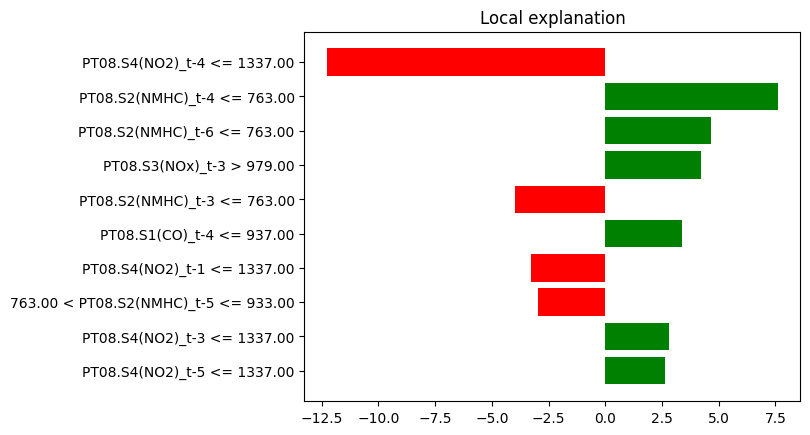

In [88]:
explain_model(X_train, model, X_test[12], features_names=input_features)

Let's try with a different model: LSTM

In [89]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

In [90]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
234/234 [==============================] - 2s 3ms/step - loss: 291.7474 - val_loss: 34.9583
Epoch 2/100
234/234 [==============================] - 1s 2ms/step - loss: 137.5904 - val_loss: 52.6617
Epoch 3/100
234/234 [==============================] - 1s 2ms/step - loss: 84.9458 - val_loss: 68.5351
Epoch 4/100
234/234 [==============================] - 1s 2ms/step - loss: 62.8705 - val_loss: 69.4268
Epoch 5/100
234/234 [==============================] - 1s 2ms/step - loss: 49.8949 - val_loss: 58.6628
Epoch 6/100
234/234 [==============================] - 1s 2ms/step - loss: 40.9435 - val_loss: 42.4088
Epoch 7/100
234/234 [==============================] - 1s 2ms/step - loss: 37.1955 - val_loss: 34.2723
Epoch 8/100
234/234 [==============================] - 1s 2ms/step - loss: 32.4418 - val_loss: 38.3155
Epoch 9/100
234/234 [==============================] - 1s 2ms/step - loss: 29.0886 - val_loss: 33.9378
Epoch 10/100
234/234 [==============================] - 1s 2ms/step - l

In [91]:
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

59/59 [==============================] - 0s 820us/step
3.1466732648506475


In [92]:
print(y_pred[19])
print(y_test[19])

[8.709218]
[8.2]


2813/2813 [==============================] - 2s 687us/step
Predicted LIME Value:  [13.10145993]
('PT08.S4(NO2)_t-0 <= 1336.75', -4.700143213380959)
('PT08.S2(NMHC)_t-0 > 1138.00', -2.6168129631748007)
('PT08.S5(O3)_t-0 > 1285.25', -1.2799540742568283)
('C6H6(GT)_t-0 > 14.70', -1.0104685850356687)
('PT08.S3(NOx)_t-0 <= 669.00', 0.7742740435909204)
('NOx(GT)_t-0 > 308.00', 0.7437259671784292)
('PT08.S4(NO2)_t-1 <= 1337.00', -0.729093184680695)
('35.30 < RH_t-0 <= 49.80', 0.6549742662314432)
('PT08.S4(NO2)_t-4 <= 1337.00', -0.6181182174119122)
('PT08.S4(NO2)_t-5 <= 1337.00', -0.5959781719424461)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
PT08.S4(NO2), with a weight of -6.643333,
PT08.S2(NMHC), with a weight of -2.616813,
PT08.S5(O3), with a weight of -1.279954,
C6H6(GT), with a weight of -1.010469,
PT08.S3(NOx), with a weight of 0.774274,
NOx(GT), with a weight of 0.743726,
RH, with a weight of 0.654974.
The model gave the most importance to the feature PT08.S4(NO2) at time step t-0, with a weight of -4.700143
For this specific instance, it looks like the model relies heavily on PT08.S4(NO2), PT08.S2(NMHC), PT08.S5(O3), C6H6(GT).


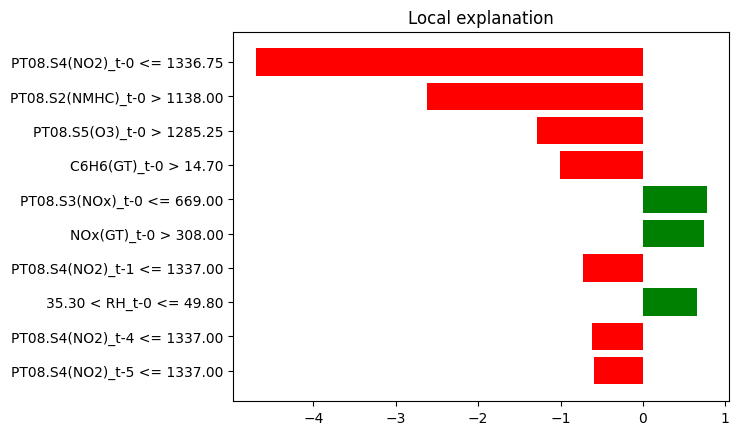

In [93]:
explain_model(X_train, model, X_test[19], input_features)

Let's try to use the XCM Model with explainability-by-design component on this dataset:


Dataset loaded
Training set size: 7480
Testing set size: 1871
X_train.shape:  (7480, 7, 12, 1)
X_test.shape:  (1871, 7, 12, 1)

Training on fold 1
XCM Model Loaded
Epoch 1/100
79/79 [==============================] - 1s 6ms/step - loss: 161.6763 - mean_absolute_error: 11.8928 - val_loss: 345.6011 - val_mean_absolute_error: 17.9023
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 54.2472 - mean_absolute_error: 6.5448 - val_loss: 108.1633 - val_mean_absolute_error: 9.4064
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 12.9526 - mean_absolute_error: 2.8618 - val_loss: 71.9776 - val_mean_absolute_error: 7.3979
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 5.1933 - mean_absolute_error: 1.7223 - val_loss: 29.1356 - val_mean_absolute_error: 4.1227
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 5.0945 - mean_absolute_error: 1.7399 - val_loss: 44.2162 - val_mean_absolute_error: 5.6226
Epoch 6

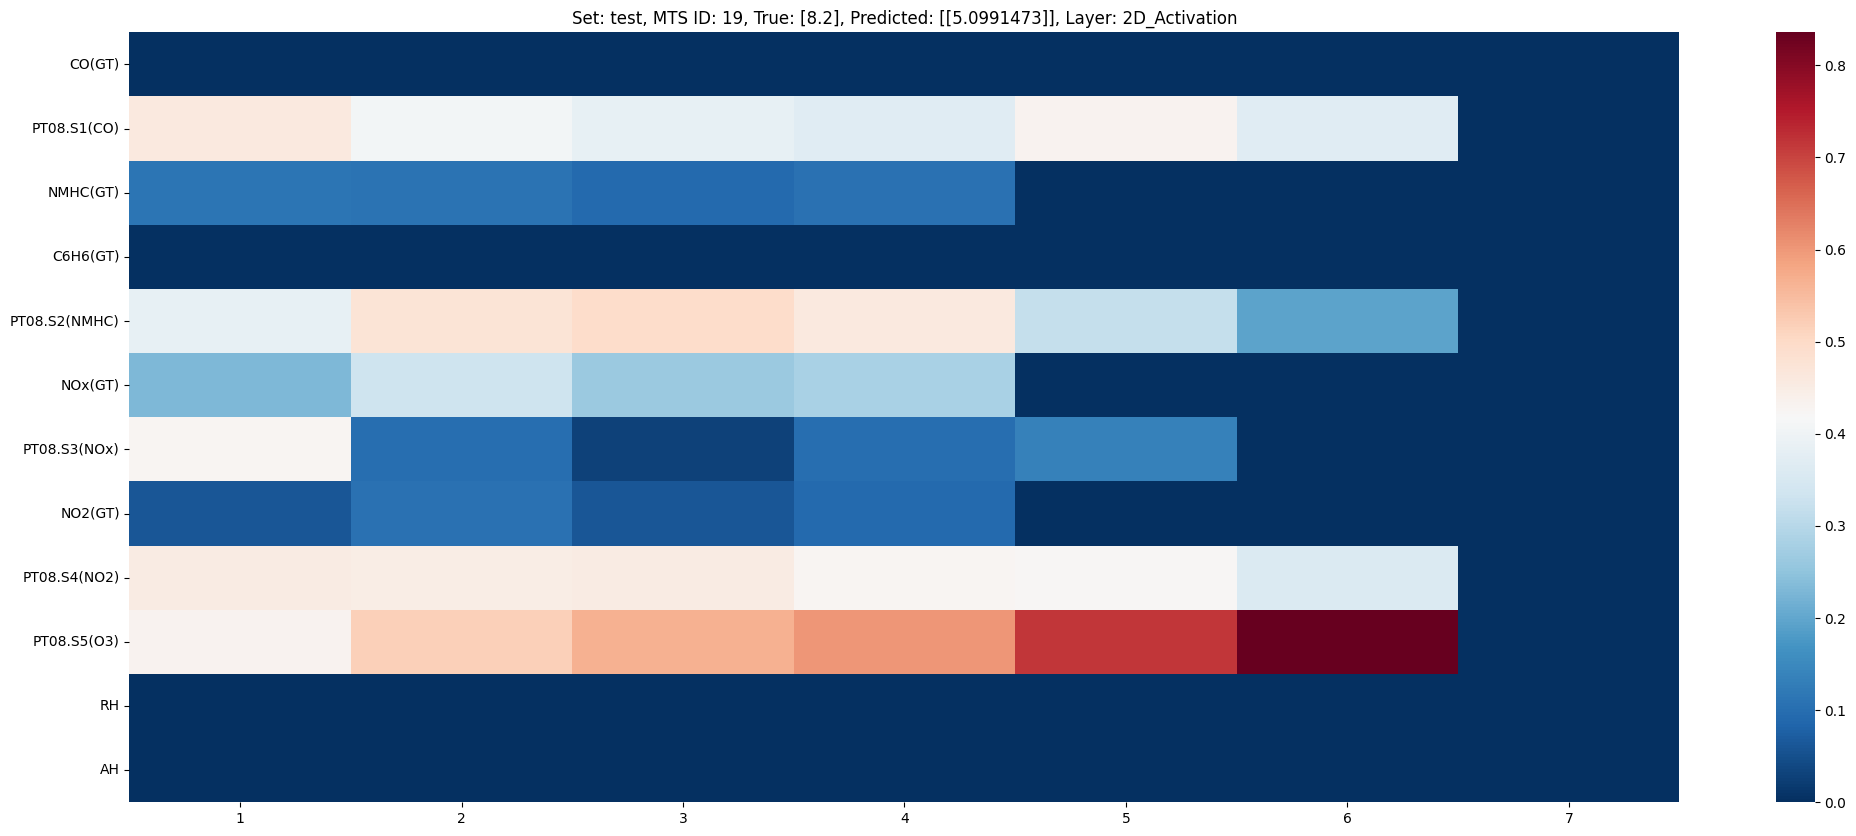

In [94]:
xcm_start(X_train, y_train, X_test, y_test, input_features)

Let's try to use the model of Istanbul Stock Exchange:

In [95]:
df = pd.read_excel("data_akbilgic.xlsx")

In [96]:
df.tail(14)

date  TL BASED ISE  USD BASED ISE        SP       DAX      FTSE  \
522 2011-02-03     -0.024478      -0.027850  0.002351  0.001392 -0.002804   
523 2011-02-04      0.024507       0.013959  0.002880  0.003127  0.002354   
524 2011-02-07     -0.006196       0.008553  0.006221  0.009298  0.008898   
525 2011-02-08      0.005356       0.006886  0.004176  0.005425  0.006638   
526 2011-02-09      0.004823      -0.003255 -0.002790 -0.000320 -0.006423   
527 2011-02-10     -0.017664      -0.024921  0.000749  0.002644 -0.005351   
528 2011-02-11      0.004782       0.006418  0.005492  0.004204  0.007101   
529 2011-02-14     -0.002498       0.000405  0.002382  0.003444 -0.000462   
530 2011-02-15      0.003606       0.000893 -0.003240  0.000461 -0.003803   
531 2011-02-16      0.008599       0.013400  0.006238  0.001925  0.007952   
532 2011-02-17      0.009310       0.015977  0.003071 -0.001186  0.000345   
533 2011-02-18      0.000191      -0.001653  0.001923  0.002872 -0.000723   
534 2011-02-21     -0.013069      -0.013706 -0.020742 -0.014239 -0.011275   
535 2011-02-22     -0.007246      -0.019442  0.000000 -0.000473 -0.002997   

       NIKKEI   BOVESPA        EU        EM  
522 -0.002489  0.001154 -0.002883  0.000476  
523  0.010695 -0.022662  0.002761 -0.003185  
524  0.004591  0.001424  0.008217 -0.003346  
525  0.004140  0.006238  0.003980 -0.004499  
526 -0.001708 -0.023895 -0.003024 -0.014249  
527 -0.001148  0.005590 -0.003742 -0.014760  
528  0.011241  0.018077  0.004727  0.003931  
529  0.000000  0.012123  0.000169  0.013448  
530  0.001968 -0.003266 -0.000550 -0.001430  
531  0.005717  0.018371  0.006975  0.003039  
532  0.002620  0.001686 -0.000581  0.001039  
533  0.000568  0.005628  0.000572  0.006938  
534  0.001358 -0.011942 -0.012615 -0.000958  
535 -0.017920 -0.012252 -0.005465 -0.014297

<AxesSubplot: >

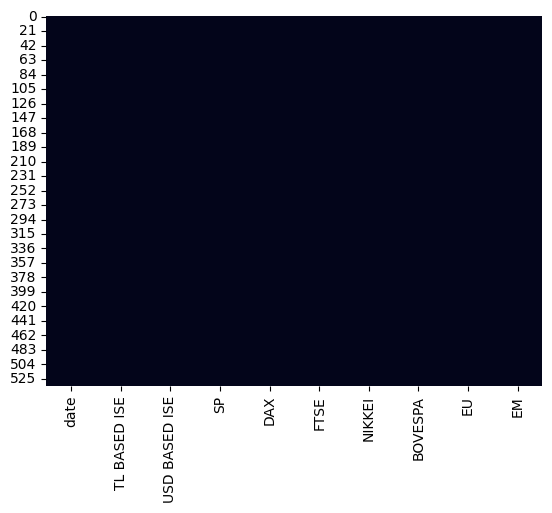

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna(), cbar=False)

Let's say we want to predict USD Based ISE.

In [98]:
df.set_index('date', inplace=True)
df = df.rename(columns={'USD BASED ISE': 'Y'})

In [99]:
df.head(4)

TL BASED ISE         Y        SP       DAX      FTSE    NIKKEI  \
date                                                                         
2009-01-05      0.035754  0.038376 -0.004679  0.002193  0.003894  0.000000   
2009-01-06      0.025426  0.031813  0.007787  0.008455  0.012866  0.004162   
2009-01-07     -0.028862 -0.026353 -0.030469 -0.017833 -0.028735  0.017293   
2009-01-08     -0.062208 -0.084716  0.003391 -0.011726 -0.000466 -0.040061   

             BOVESPA        EU        EM  
date                                      
2009-01-05  0.031190  0.012698  0.028524  
2009-01-06  0.018920  0.011341  0.008773  
2009-01-07 -0.035899 -0.017073 -0.020015  
2009-01-08  0.028283 -0.005561 -0.019424

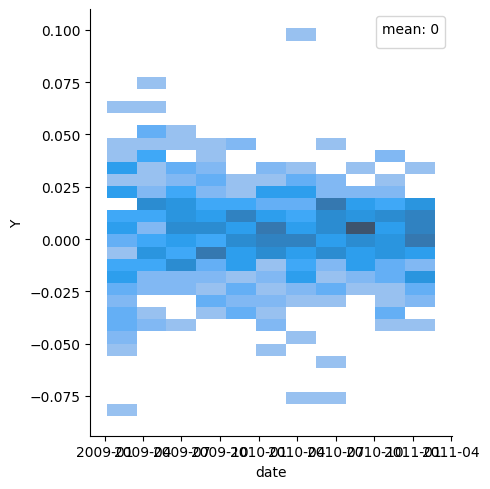

In [100]:
sns.displot(data=df, x='date', y='Y')
plt.legend(title='mean: {:,.0f}'.format(df["Y"].mean()), labels=[])
plt.show()

Let's generate samples, train and test set:

In [101]:
from sklearn.model_selection import train_test_split

features = df.columns.values
index = np.argwhere(features=='Y')
input_features = np.delete(features, index)
output_feature = np.array(['Y'])
window_size = 7
stride = 1

# create lists to store the samples and labels
samples = []
labels = []

# slide the window over the data and extract samples and labels
for i in range(0, len(df) - window_size+1, stride):
    # extract the input features for this window
    X = df.iloc[i:i+window_size, df.columns != 'Y'].values
    samples.append(X)

    # extract the output feature for this window
    y = df.iloc[i+window_size-1][output_feature]
    labels.append(y)

# convert the lists to numpy arrays
samples = np.array(samples)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, shuffle=False)

Now the model:

In [102]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [103]:
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
4/4 [==============================] - 0s 25ms/step - loss: 5.2098e-04 - val_loss: 2.8865e-04
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 4.6645e-04 - val_loss: 2.9604e-04
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 4.6579e-04 - val_loss: 2.8610e-04
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 4.6154e-04 - val_loss: 2.7621e-04
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 4.6215e-04 - val_loss: 2.7280e-04
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 4.5990e-04 - val_loss: 2.7661e-04
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 4.5780e-04 - val_loss: 2.8446e-04
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 4.5732e-04 - val_loss: 2.8232e-04
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 4.5545e-04 - val_loss: 2.8169e-04
Epoch 10/100
4/4 [==============================] - 0s

In [104]:
y_pred = model.predict(X_test)
print(y_pred)

4/4 [==============================] - 0s 607us/step
[[ 1.0372496e-03]
 [ 2.0043389e-04]
 [-3.6874244e-03]
 [ 6.4122863e-03]
 [ 1.9887079e-02]
 [ 1.4615484e-02]
 [ 6.4438293e-03]
 [ 5.9482101e-03]
 [ 6.9688028e-03]
 [-8.3173043e-04]
 [ 5.4031312e-03]
 [-1.8376892e-03]
 [ 2.3316836e-03]
 [ 3.6793204e-03]
 [-1.5654543e-03]
 [ 1.1860490e-02]
 [ 1.1067992e-02]
 [ 1.0646215e-02]
 [-1.6653677e-05]
 [ 3.0511641e-04]
 [-2.4948432e-04]
 [ 1.8051325e-03]
 [-6.5989457e-03]
 [ 7.8063030e-03]
 [ 8.3519882e-03]
 [-9.5821656e-03]
 [-2.8335636e-03]
 [ 9.6654911e-03]
 [ 8.6535634e-03]
 [ 1.8601476e-03]
 [-6.4006709e-03]
 [-1.0804294e-02]
 [ 3.1290876e-03]
 [ 4.4824928e-03]
 [-1.2310797e-02]
 [ 6.5138526e-03]
 [ 1.3681006e-02]
 [ 1.0441628e-03]
 [-8.7700961e-03]
 [ 8.6761545e-03]
 [ 1.6192667e-02]
 [-1.4032105e-03]
 [-1.6128859e-02]
 [-8.2825106e-03]
 [ 3.4207501e-04]
 [ 2.0733012e-03]
 [-1.7269810e-03]
 [-9.5724948e-03]
 [-4.6617836e-03]
 [ 4.2887665e-03]
 [ 1.5301576e-02]
 [ 6.4849257e-03]
 [ 6.512892

In [105]:
print(y_pred[20])
print(y_test[20])

[-0.00024948]
[-0.00814098]


In [106]:
print(mean_absolute_error(y_pred, y_test))

0.014742216490814862


Ok now let's see the LIME explanation:

2813/2813 [==============================] - 1s 372us/step
Predicted LIME Value:  [0.00866924]
('BOVESPA_t-1 > 0.01', 0.007602569348782422)
('SP_t-1 > 0.01', 0.00628771587924379)
('FTSE_t-3 > 0.01', 0.005843701496272806)
('TL BASED ISE_t-3 <= -0.01', -0.005034371581634189)
('BOVESPA_t-3 > 0.01', 0.00404186867240021)
('NIKKEI_t-1 > 0.01', -0.0032432232454305287)
('TL BASED ISE_t-6 > 0.01', -0.0023475019196077087)
('EU_t-1 > 0.01', -0.0019738356118414453)
('0.00 < BOVESPA_t-2 <= 0.01', 0.001937579042949003)
('FTSE_t-1 > 0.01', -0.0017261048009524387)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
BOVESPA, with a weight of 0.013582,
SP, with a weight of 0.006288,
FTSE, with a weight of 0.004118,
TL BASED ISE, with a weight of -0.007382,
NIKKEI, with a weight of -0.003243,
EU, with a weight of -0.001974.
The model gave the most importance to the feature BOVESPA at time step t-1, with a weight of 0.007603
For this specific instance, it looks like the model relies heavily on BOVESPA, TL BASED ISE, SP, FTSE.


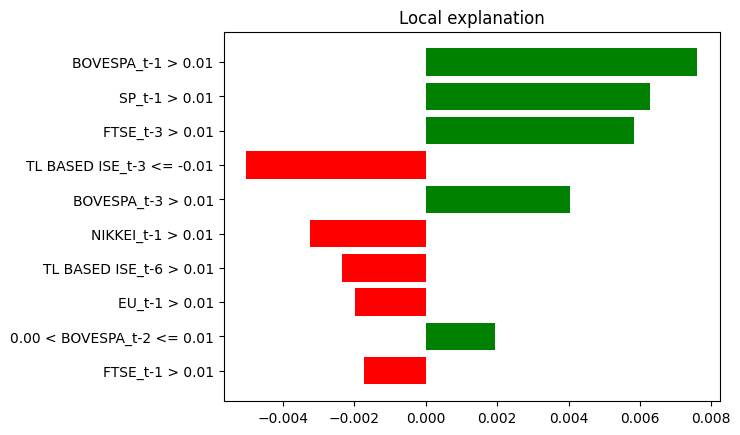

In [107]:
explain_model(X_train, model, X_test[12], features_names=input_features)

Let's try with LSTM:

In [108]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

In [109]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
14/14 [==============================] - 2s 47ms/step - loss: 4.4530e-04 - val_loss: 2.5348e-04
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 3.8826e-04 - val_loss: 2.1675e-04
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3.2724e-04 - val_loss: 2.0325e-04
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 2.7905e-04 - val_loss: 1.8456e-04
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 2.3903e-04 - val_loss: 1.5127e-04
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 2.1594e-04 - val_loss: 1.3796e-04
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 1.8253e-04 - val_loss: 1.3069e-04
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 1.6353e-04 - val_loss: 1.2606e-04
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 1.4727e-04 - val_loss: 1.0548e-04
Epoch 10/100
14/14 [================

In [110]:
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

4/4 [==============================] - 0s 1ms/step
0.004702355972920712


In [111]:
print(y_pred[19])
print(y_test[19])

[0.00711162]
[0.0076885]


2813/2813 [==============================] - 2s 671us/step
Predicted LIME Value:  [0.01943255]
('TL BASED ISE_t-0 > 0.01', 0.031273535366215466)
('NIKKEI_t-1 > 0.01', -0.002706616540425724)
('-0.01 < EM_t-0 <= 0.00', -0.0017227375867462328)
('TL BASED ISE_t-1 <= -0.01', -0.001261377009169649)
('DAX_t-2 > 0.01', -0.0009859126420608386)
('NIKKEI_t-0 <= -0.01', -0.0009627771584969318)
('FTSE_t-2 > 0.01', 0.0008111591082184645)
('-0.01 < EU_t-0 <= 0.00', -0.0007904015077197452)
('0.00 < BOVESPA_t-0 <= 0.01', -0.0005899822958240626)
('0.00 < DAX_t-0 <= 0.01', -0.0005440115200402146)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
TL BASED ISE, with a weight of 0.030012,
NIKKEI, with a weight of -0.003669,
EM, with a weight of -0.001723,
DAX, with a weight of -0.00153,
FTSE, with a weight of 0.000811,
EU, with a weight of -0.00079,
BOVESPA, with a weight of -0.00059.
The model gave the most importance to the feature TL BASED ISE at time step t-0, with a weight of 0.031274
For this specific instance, it looks like the model relies heavily on TL BASED ISE, NIKKEI, EM, DAX.


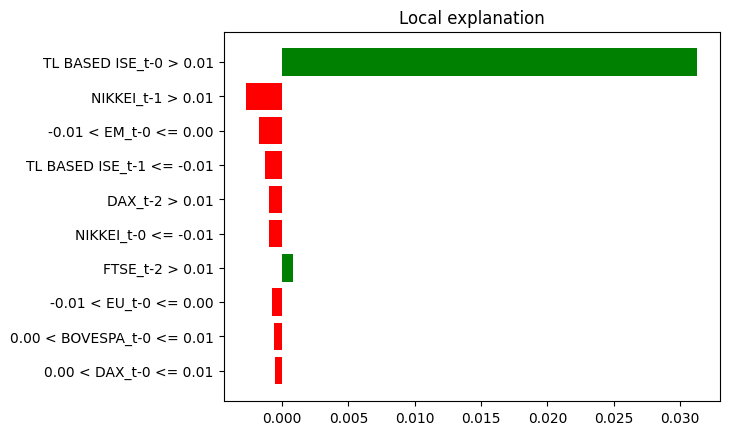

In [112]:
explain_model(X_train, model, X_test[19], input_features)

Let's check the xcm model:

In [113]:
len(X_train)

424


Dataset loaded
Training set size: 424
Testing set size: 106
X_train.shape:  (424, 7, 8, 1)
X_test.shape:  (106, 7, 8, 1)

Training on fold 1
XCM Model Loaded
Epoch 1/100
5/5 [==============================] - 1s 34ms/step - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0011 - val_mean_absolute_error: 0.0276
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_absolute_error: 0.0296 - val_loss: 6.1202e-04 - val_mean_absolute_error: 0.0188
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 8.4454e-04 - mean_absolute_error: 0.0237 - val_loss: 4.9259e-04 - val_mean_absolute_error: 0.0169
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 7.3975e-04 - mean_absolute_error: 0.0226 - val_loss: 4.8006e-04 - val_mean_absolute_error: 0.0167
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 7.1919e-04 - mean_absolute_error: 0.0226 - val_loss: 4.8290e-04 - val_mean_absolute_error: 0.0168
Epoch 6

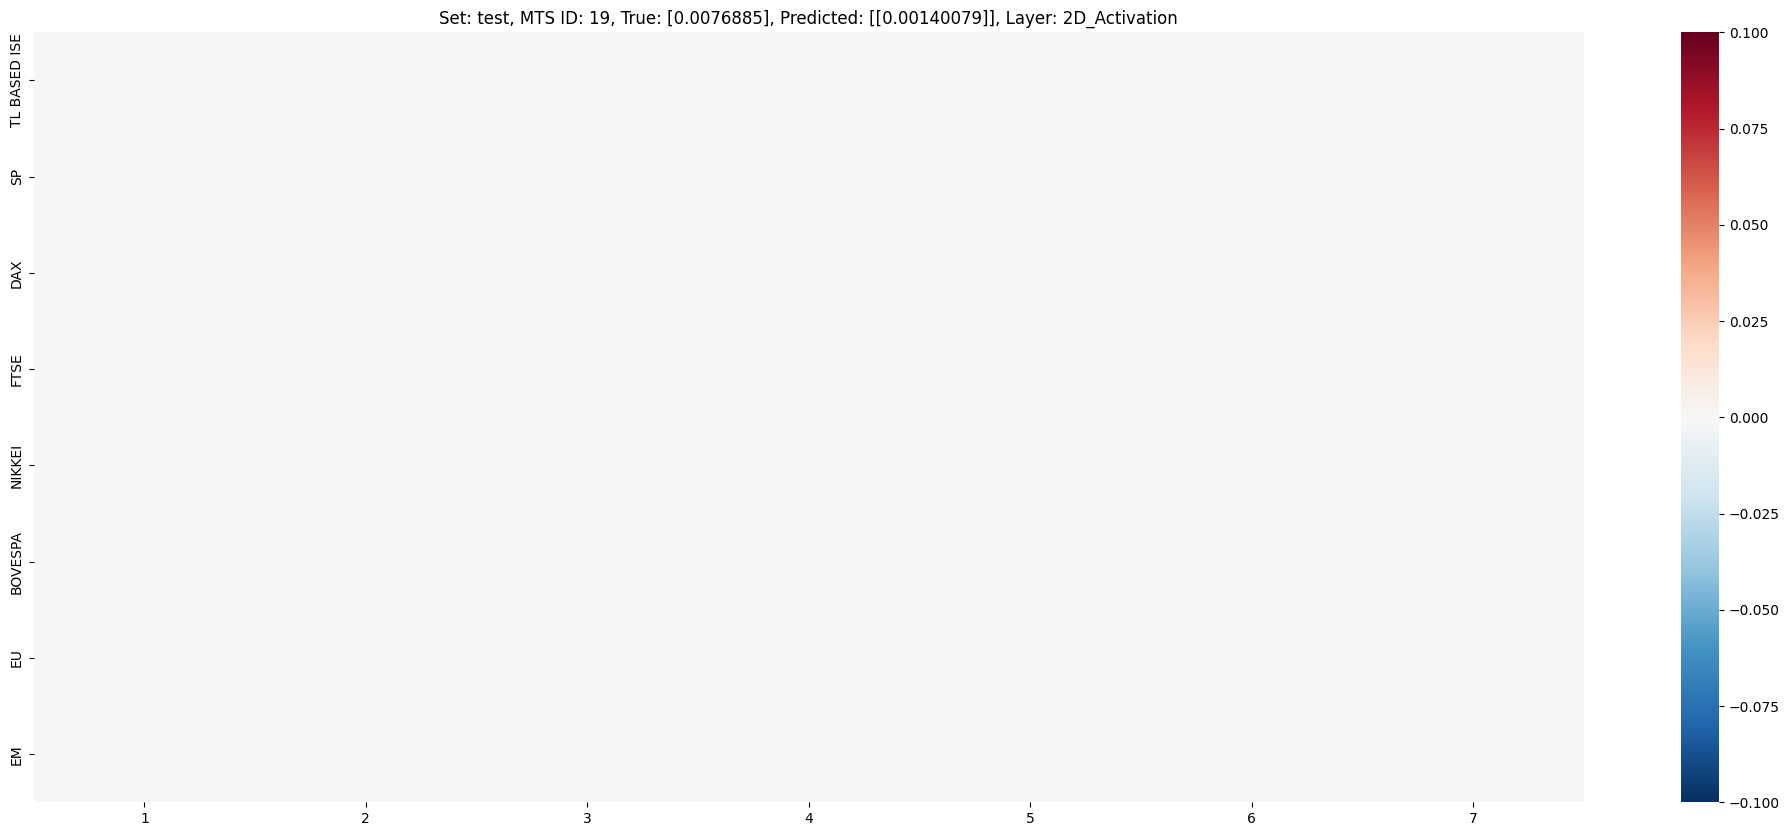

In [114]:
model_xcm = xcm_start(X_train, y_train, X_test, y_test, yticklabels=input_features)

In [115]:
X_test.shape

(106, 7, 8)

In [116]:
X_test_xcm = np.reshape(
    np.array(X_test),
    (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1),
    order="C",
)

model_xcm.predict(X_test_xcm)

4/4 [==============================] - 0s 1ms/step


array([[0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.00140079],
       [0.001

In [117]:
print(y_test)

[[ 0.00660358]
 [ 0.00032606]
 [ 0.01037803]
 [-0.00688954]
 [ 0.00231497]
 [ 0.01277985]
 [ 0.01594248]
 [ 0.01018349]
 [ 0.00878905]
 [-0.01059654]
 [ 0.00824221]
 [ 0.01130961]
 [ 0.02759418]
 [ 0.00088613]
 [ 0.000196  ]
 [ 0.03779504]
 [ 0.00037387]
 [ 0.01568416]
 [-0.00412852]
 [ 0.0076885 ]
 [-0.00814098]
 [-0.00769588]
 [-0.01132673]
 [ 0.02209617]
 [ 0.00179629]
 [ 0.00852098]
 [-0.00640193]
 [-0.0427355 ]
 [ 0.01443257]
 [-0.00130669]
 [ 0.00703944]
 [ 0.04267029]
 [-0.00437412]
 [-0.00573413]
 [ 0.00852324]
 [-0.01660256]
 [-0.01187706]
 [-0.01733661]
 [ 0.00637886]
 [-0.03563273]
 [-0.03754109]
 [-0.00044865]
 [ 0.00353471]
 [-0.02363106]
 [-0.03477944]
 [ 0.01117932]
 [ 0.0191463 ]
 [ 0.016953  ]
 [ 0.0041029 ]
 [ 0.01035651]
 [ 0.0081574 ]
 [-0.01246241]
 [-0.03185293]
 [-0.02008971]
 [ 0.02218826]
 [ 0.00468932]
 [-0.02670327]
 [-0.01964118]
 [-0.0169853 ]
 [-0.01739167]
 [ 0.01821724]
 [ 0.01217666]
 [ 0.0124789 ]
 [ 0.00423297]
 [ 0.000634  ]
 [ 0.00043838]
 [-0.00558

In [118]:
X_test_xcm.shape

(106, 7, 8, 1)

In [119]:
mean_absolute_error(y_test, model_xcm.predict(X_test_xcm))

4/4 [==============================] - 0s 1ms/step


0.012717954556603772